# Prepare the data

In [1]:
import re
import json
import pandas as pd
import spacy

pd.set_option("display.max_colwidth", 4000)
pd.set_option("display.max_rows", 4000)

from tqdm import tqdm

tqdm.pandas()

# Load the model and data files
spacy_model = spacy.load("en_core_web_sm")

with open("../investigation_notebooks/train_samples.jsonl", "r") as f:
    lines = [l.strip() for l in f]
df = pd.DataFrame([json.loads(l) for l in lines])

# TODO: Have a generic preprocessing step
df["summary"] = df["summary"].apply(
    lambda s: re.sub(
        r" - USATODAY.com$",
        "",
        s,
    )
)

# Tokenize the summaries
df["summary_tokens"] = df["summary"].progress_apply(
    lambda s: [t.text for t in spacy_model(s)]
)

# Compute the modified density
df["modified_density"] = df.apply(
    lambda row: row["density"] / len(row["summary_tokens"]), axis=1
)

# Find the new thresholds
th1, th2 = df["modified_density"].quantile(1 / 3), df["modified_density"].quantile(
    2 / 3
)
cov_th = 0.85

# Don't also consider high coverage summaries as abstractive ones
df["modified_density_bin"] = df.apply(
    lambda row: "abstractive"
    if row["modified_density"] <= th1 and row["coverage"] <= cov_th
    else "mixed"
    if row["modified_density"] <= th2
    else "extractive",
    axis=1,
)


# Slice only part of the dataset
df = df[df["density_bin"] != "extractive"].copy().reset_index(drop=True)

100%|██████████| 10000/10000 [01:31<00:00, 109.86it/s]


In [2]:
df.loc[
    df["summary"].apply(
        lambda s: any([c in s for c in "?!"])
    ),
    ["summary"],
]

summary
7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                At least we know Sofia is probably writing this herself!
8                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Who stood out?
105                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Can your boss claim a religious objection to providing free contraception?
135                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# Heuristic 1: Percentage of tokens inside quotes

In [3]:
def compute_quotes_coverage(summary_tokens):
    """
    Compute the quotes coverage for a summary
    
    summary_tokens: A list of strings (tokens)
    
    returns:
    A value in range [0, 1] representing the percentage of tokens
    that are enclosed in quotes
    """
    n_tokens_inside = 0
    # Keep track of nested quotes
    quotes_stack = []
    # Count the number of tokens inside the current quotes range
    tokens_in_quotes = []

    # TODO: Is single quotation ' needed as well?
    quotes = '”“‘’"'

    for token in summary_tokens:
        #  This token is inside a candidate quotes range
        if quotes_stack and token not in quotes:
            tokens_in_quotes[-1] += 1

        # The current token is a quotation
        if token in quotes:
            # This is the end of a quotes range
            if quotes_stack and abs(ord(token) - ord(quotes_stack[-1])) <= 1:
                quotes_stack.pop(-1)
                # Increment the number of tokens inside quotes range
                # only when the range ends
                n_tokens_inside += tokens_in_quotes[-1]
                tokens_in_quotes.pop(-1)

            # This is the start of a new range
            else:
                quotes_stack.append(token)
                tokens_in_quotes.append(0)

    n_non_quotes_tokens = len(
        [token for token in summary_tokens if token not in quotes]
    )
    return n_tokens_inside / n_non_quotes_tokens

In [4]:
df["quotes_coverage"] = df.progress_apply(
    lambda row: (compute_quotes_coverage(row["summary_tokens"])), axis=1,
)

100%|██████████| 6592/6592 [00:00<00:00, 52846.47it/s]


In [5]:
df.sort_values(by="quotes_coverage", ascending=False)[
    [
        "density_bin",
        "modified_density_bin",
#         "modified_density",
#         "density",
        "quotes_coverage",
        "summary",
        "title"
    ]
].head(10)

density_bin modified_density_bin  quotes_coverage  \
2930        mixed           extractive              1.0   
5764        mixed           extractive              1.0   
5269        mixed           extractive              1.0   
3717  abstractive                mixed              1.0   
4987  abstractive                mixed              1.0   
574         mixed                mixed              1.0   
5249  abstractive                mixed              1.0   
4153  abstractive          abstractive              1.0   
2996        mixed           extractive              1.0   
2612  abstractive                mixed              1.0   

                                                                                                                 summary  \
2930                                      "I approved it, and I'll do it again if presented with the same circumstances"   
5764             "Each day the Sami are reminded of their dependence on nature, and the fragility of that relationship."   
5269                                                                         "I have concluded that person cannot be me"   
3717                                                                                                "I double dare you."   
4987                                                                                          "It's been very humbling."   
574   ‘The photographer called it Bankers At Leadenhall Market, but everyone in the picture actually works in insurance’   
5249                                                                                   "I have three questions for you."   
4153                                                                                            "Hey Jimmy... I farted."   
2996                                   “Where is she? If there's no ashes and there's no baby, what did he do with her?”   
2612                                                                                           "There is nothing there."   

                                                                                                     title  
2930                                            Dallas Police Chief Defends Use of 'Bomb Robot' on Suspect  
5764              Off the Grid: Preserving the tradition of reindeer herding in Scandinavia’s Sami culture  
5269                                               Boris Johnson Drops Out of Conservative Leadership Race  
3717                                                             18 GIFs That Sum Up Playing Truth Or Dare  
4987                                                        Meet the Photographer Behind Baton Rouge Photo  
574   That’s me in the picture: Patrick Sheehy drinking a pint in Leadenhall Market, London, December 2011  
5249                                Arnold Schwarzenegger to Climate Change Deniers: "I Don't Give a Damn"  
4153                          Kevin Hart got so scared in a haunted house with Jimmy Fallon that he farted  
2996     Police found 12 bodies in a storage unit three weeks ago. So why isn’t anyone facing charges yet?  
2612                                                     How four words rewrote Bayer-Monsanto deal script

In [6]:
# Find the number of percentage of samples having
# quotes coverage that is higher than 0.8!
df[df["quotes_coverage"]>=0.8].shape[0]

17

In [7]:
df["quotes_coverage"].describe()

count    6592.000000
mean        0.017105
std         0.081639
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: quotes_coverage, dtype: float64

### Check the relation between quotes_coverage and density

In [8]:
import seaborn as sns

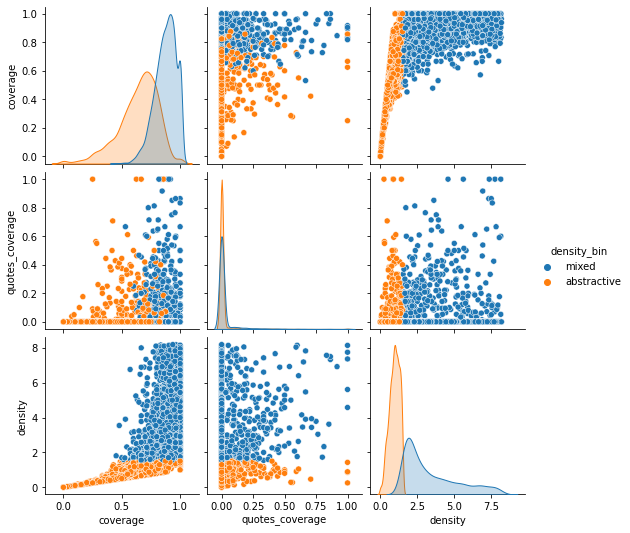

In [9]:
sns.pairplot(
    data=df[["density_bin", "coverage", "quotes_coverage", "density"]],
    hue="density_bin",
)

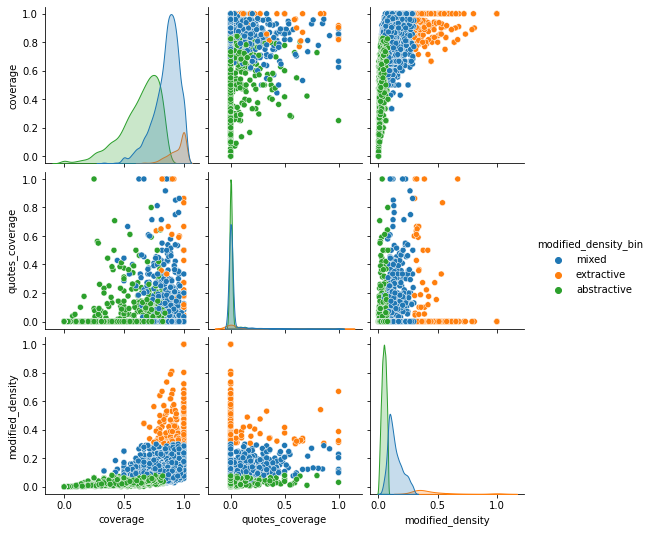

In [10]:
sns.pairplot(
    data=df[["modified_density_bin", "coverage", "quotes_coverage", "modified_density"]],
    hue="modified_density_bin",
    hue_order=["mixed", "extractive", "abstractive"]
)

# Heuristic 2: Having a strange ending

In [11]:
def has_strange_ending(summary):
    """
    Check if the summary ends abruptly
    summary_tokens: A string

    returns:
    A boolean value
    """
    summary_tokens = spacy_model(summary)

    last_token_text = summary_tokens[-1].text.lower()
    # List of pos tags can be found through: https://universaldependencies.org/u/pos/
    last_token_pos = summary_tokens[-1].pos_

    if last_token_text in ".":
        return False

    if last_token_text in ",":
        return True

    if (
        last_token_pos in ["DET", "INTJ", "CCONJ", "AUX", "SCONJ", "X"]
        and last_token_text != "all"
    ):
        return True

    if last_token_pos == "PRON" and last_token_text in ["what", "who", "which", "that"]:
        return True

    return False

In [12]:
df["has_strange_ending"] = df["summary"].progress_apply(has_strange_ending)

100%|██████████| 6592/6592 [00:49<00:00, 133.77it/s]


In [13]:
df.loc[df["has_strange_ending"] == True, ["summary"]].shape

(42, 1)

In [14]:
df.loc[df["has_strange_ending"] == True, ["summary"]].sample(20)#, random_state=42)

summary
3432                                                   One by one, Michiko walked through the legal steps of finalizing her divorce: dividing property, determining child custody and arranging her daughter's college fund. But when it came to settling the
3070                                                                                                                                                                        http://images.scribblelive.com/2015/10/2/222b607e-4b1f-45e4-a8bd-733c18ca0f40.jpg
5955                                                                                                            Roy Hodgson should now be allowed to get on with it, Jack Wilshere can learn from Gökhan Inler and this is as exciting as qualifying will get
5216                                                                                                                                                                                                           Browse stories from Walt Bonner on FoxNews.com
2574                                                   North Korea did not retaliate as threatened Monday after a South Korean military exercise that it had warned could lead to war.At the same time, the North agreed to allow U.N. monitors access to its
4389                                                                      Runaway Christian Convert to Stay in Florida for Now, Judge Rules, A 17-year-old runaway who claims she fled her family's home in Ohio because she feared becoming the victim of an
1908                                                               Marine life is under severe threat from global warming, pollution and habitat loss, with a high risk of "major extinctions" according to a panel of experts.These are the conclusions of a
4012                                                   A 14-year-old male student last seen two months ago being beaten and dragged into a white van by Syrian security forces; a 13-year-old boy arrested with his friends and bleeding badly from his ears,
4281                                                        Greek politicians have voted to bring in an unpopular package of austerity measures designed to rein in debt levels that threaten to destabilize the country's economy.What are they voting for?A
5873                                                                                                                                                   The timing of Microsoft's Nokia acquisition may be surprising, but the decision itself is anything but
4721                                                    Hate crime and robbery indictments were brought Tuesday in two separate incidents in which suspects allegedly targeted gay men for violence at Manhattan gay bars.Two men were accused of attacking a
4263                                                      Bloomberg is reporting that Microsoft will cease development of its family of Zune-branded music players due to weak demand and a desire to focus on its smartphone platform.Zune will live on as a
5708  <p>&nbsp;The cast of <em>Sex and the City 2</em>, Sarah Jessica Parker, left, Kristin Davis, Cynthia Nixon and Kim Cattrall, &nbsp;pose for a photo at the premiere at Radio City Music Hall in New York on Monday. The film is in theaters Friday.</p>
5863                                                                      There have been recent near misses – an explosion over Russia, a mysterious crater in Nicaragua. But what would we do in the event of an actual meteor strike? Tom Lamont finds out
5692                                                       Authorities on Saturday called off their lengthy search for an abducted 4-year-old boy in one part of a California canal but said the search for missing Juliani Cardenas would continue.They have
2776                                                        The ex-wife of a Texas convict executed in 2004 for the deaths of his three children reaffirmed her belief in his guilt We

# Heuristic 3: Summary is too short
Implemented directly in snorkel

# Heuristic 4: Summary is just a date
- Implemented directly in snorkel
- TODO: What if the date is just a substantial part of a strapline?
    - How to detect this case?

# Heuristic 5: Bad summaries can contain html/js/css code
- Currently only detecting HTML tags

# Heuristic 6: A strapline can occur multiple times in the dataset
- Finding repititions of each summary is computed once as a preprocessing step

# Heuristic 7: A strapline uses 2nd person pronouns
- Current pronouns are (you, your, yours)

# Heuristic 8: A strapline can contain question/exclamation marks
- Current signals are "?" and "!"

# Heuristic 9: A strapline can use imperative speech
- I noticed that imperative verbs has the "VB" tokens
- TODO: Make sure this is right

# TODO

Other ideas:
- Heuristic ?: A bad summary is longer than the article itself

# Use snorkel

In [15]:
import dateutil
from snorkel.labeling import labeling_function

# NOTE: I am afraid of returning a NOT_STRAPLINE label
# based on any of the heuristics so I am just ABSTAINing

ABSTAIN = -1
NOT_STRAPLINE = 0
STRAPLINE = 1


@labeling_function()
def lf_mostly_quotes(x):
    quotes_coverage = compute_quotes_coverage(x["summary_tokens"])
    return STRAPLINE if quotes_coverage > 0.6 else ABSTAIN


@labeling_function()
def lf_strange_ending(x):
    strange_ending = has_strange_ending(x["summary"])
    return STRAPLINE if strange_ending else ABSTAIN


@labeling_function()
def lf_too_short(x):
    summary_n_tokens = len(x["summary_tokens"])
    return STRAPLINE if summary_n_tokens <= 5 else ABSTAIN


@labeling_function()
def lf_is_a_date(x):
    try:
        # Attempt to parse the text as a date
        dateutil.parser.parse(x["summary"])
        return STRAPLINE
    except:
        return ABSTAIN


@labeling_function()
def lf_has_HTML(x):
    # Attempt to parse the text as a date
    if re.findall(r"<[a-zA-Z0-9_]+[/]?>", x["summary"]):
        return STRAPLINE
    return ABSTAIN


@labeling_function()
def lf_has_HTML(x):
    # Attempt to parse the text as a date
    if re.findall(r"<[a-zA-Z0-9_]+[/]?>", x["summary"]):
        return STRAPLINE
    return ABSTAIN


from collections import Counter

summary_counts = Counter(
    df["summary"].apply(lambda s: re.sub(r"[^a-z0-9A-Z]", "", s)).tolist()
)


@labeling_function()
def lf_is_repeated(x):
    if summary_counts.get(re.sub(r"[^a-z0-9A-Z]", "", x["summary"]), 0) > 1:
        return STRAPLINE
    return ABSTAIN


@labeling_function()
def lf_has_1st_or_2nd_person_pronoun(x):
    list_of_person_pronouns = [
        "i",
        "me",
        "mine",
        "myself",
        "we",
        "our",
        "ours",
        "ourself",
        "ourselves",
        "you",
        "your",
        "yours",
        "yourself",
        "yourselves"
    ]
    tokens = [t.lower() for t in x["summary_tokens"]]
    if any([t in list_of_person_pronouns for t in x["summary_tokens"]]):
        return STRAPLINE
    return ABSTAIN

@labeling_function()
def lf_has_quotation_exclamation_marks(x):
    if any([c in x["summary"] for c in "?!"]):
        return STRAPLINE
    return ABSTAIN


@labeling_function()
def lf_imperative_speech(x):
    summary_tokens = spacy_model(x["summary"])
    if summary_tokens[0].tag_ == "VB":
        return STRAPLINE
    return ABSTAIN

In [16]:
from snorkel.labeling import PandasLFApplier

lfs = [
    lf_mostly_quotes,
    lf_strange_ending,
    lf_too_short,
    lf_is_a_date,
    lf_has_HTML,
    lf_is_repeated,
    lf_has_1st_or_2nd_person_pronoun,
    lf_has_quotation_exclamation_marks,
    lf_imperative_speech
]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df)

100%|██████████| 6592/6592 [01:37<00:00, 67.34it/s]


In [17]:
# Check the labels assigned to the samples by the labeling functions
L_train

array([[-1, -1,  1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1,  1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1,  1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [18]:
# Check the overlaps/conflicts between labeling functions
# Note: No conflicts for now since I am not using the NOT_STRAPLINE label
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

j Polarity  Coverage  Overlaps  Conflicts
lf_mostly_quotes                    0      [1]  0.004703  0.001669        0.0
lf_strange_ending                   1      [1]  0.006371  0.001365        0.0
lf_too_short                        2      [1]  0.022907  0.006675        0.0
lf_is_a_date                        3      [1]  0.000303  0.000303        0.0
lf_has_HTML                         4      [1]  0.001669  0.001062        0.0
lf_is_repeated                      5      [1]  0.011377  0.005461        0.0
lf_has_1st_or_2nd_person_pronoun    6      [1]  0.075394  0.022148        0.0
lf_has_quotation_exclamation_marks  7      [1]  0.054157  0.016080        0.0
lf_imperative_speech                8      [1]  0.021541  0.010771        0.0

In [19]:
from snorkel.labeling.model import LabelModel

# Merge the labels into a single label with probability
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

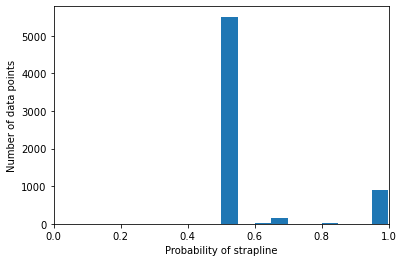

In [20]:
import matplotlib.pyplot as plt

def plot_probabilities_histogram(Y, label):
    plt.hist(Y, bins=10)
    plt.xlabel(f"Probability of {label}")
    plt.ylabel("Number of data points")
    plt.xlim(0, 1)
    plt.show()

probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, STRAPLINE], "strapline")

# Detected straplines
- Check the samples having probability > 0.5

In [21]:
number_of_straplines = df.loc[(probs_train[:, 1] > 0.5), ["summary"]].shape[0]
print(
    f"""{number_of_straplines} straplines in the sample dataset
Representing {round(100 * number_of_straplines / df.shape[0], 2)}% of it"""
)

1087 straplines in the sample dataset
Representing 16.49% of it


In [22]:
df["probability_of_being_strapline"] = probs_train[:,1]

In [23]:
strapline_summaries = (
    df[(probs_train[:, 1] > 0.5)]
    .copy()
    .sort_values(by="probability_of_being_strapline", ascending=False)
)

In [24]:
strapline_summaries["modified_density_bin"].value_counts()

abstractive    582
mixed          426
extractive      79
Name: modified_density_bin, dtype: int64

In [25]:
# This is the last cell in the notebook
# It's too long since it's showing all the detected straplines
strapline_summaries[["summary", "probability_of_being_strapline", "title"]]

summary  \
3390                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Get your jazz hands ready, Fosse fanatics! A new listing near St. Francis Wood in San Francisco comes complete with a huge dance studio to practice your moves. The mirror-lined space with hardwoods and spotlight-like tract lighting was a family room in its former life (see before and after pics   
5358                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       